In [ ]:
import predspracovanie

import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle

import copy

import tensorflow.keras.backend as backend

from tensorflow.keras.regularizers import l2

import os

# os.environ["CUDA_DEVICE_ORDER"] = "GPU"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import os
import datetime

import wandb
from wandb.keras import WandbCallback


In [ ]:
items = [
    '30m-item56', 
         '30m-item57', '30m-item58', '30m-item59', '30m-item61', '30m-item62', '30m-item66', '30m-item67', '30m-item69', '30m-item71', '30m-item72', '30m-item73', '30m-item75',
    '30m-item76', 
    '30m-item77'
        ]
df = pickle.load( open( "/home/richard_stana/programing/clanok/data/picklnute/30min.p", "rb" ) )
# df = predspracovanie.make_dataset(df)
df = df.drop(["30m-item60", "30m-item63", "30m-item64", "30m-item65", "30m-item68", "30m-item70", "30m-item74"], axis=1)
# df = df[actual_item]
# predspracovanie.draw(df, datum_alebo_cisla="cislo", y1_orig=df[actual_item])

In [ ]:
# train_df = df[76:44000]
# val_df = df[44001:46655]
# test_df = df[46800:52389]
train_df = df[27:15549]
train1_df = df[15602:17160]
val_df = df[17160-144-1:17460]
# test_df = df[46800:52389]

In [ ]:
train_df_orig = train_df.copy()
train_df = predspracovanie.create_log_difference(train_df)
train1_df_orig = train1_df.copy()
train1_df = predspracovanie.create_log_difference(train1_df)
val_df_orig = val_df.copy()
val_df = predspracovanie.create_log_difference(val_df)
# test_df_orig = test_df.copy()
# test_df = predspracovanie.create_log_difference(test_df)

In [ ]:
val_df["30m-item77"]

In [ ]:
n_inputs = 144
n_outputs = 1

In [ ]:
def compile_and_fit(projekt, model, nazov_modelu, train_x, train_y, train_x1, train_y1, val_x, val_y, compile=False, epochs=200):
    wandb.init(project=projekt, name=nazov_modelu + str(n_outputs))

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="models_clanok/" + nazov_modelu + "future" + str(n_outputs) + ".hdf5",
        #     save_weights_only=True,
        monitor='val_mae',
        mode='min',
        save_best_only=True)
    model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
        filepath="models_clanok/" + nazov_modelu + "future" + str(n_outputs) + "1.hdf5",
        #     save_weights_only=True,
        monitor='val_mae',
        mode='min',
        save_best_only=True)

    if compile:
        model.compile(loss='mse',
                    optimizer=tf.optimizers.Adam(),
                    metrics='mae')

    history = model.fit(x=np.array(train_x).reshape((-1,n_inputs,1)),
                      y=np.array(train_y).reshape((-1,n_outputs)),
                      epochs=epochs,
                      validation_data=(np.array(val_x).reshape((-1,n_inputs,1)), np.array(val_y).reshape((-1,n_outputs))),
                      batch_size=128,
                      callbacks=[model_checkpoint_callback, 
                                     WandbCallback()
                                ])
    history = model.fit(x=np.array(train_x).reshape((-1,n_inputs,1)),
                      y=np.array(train_y).reshape((-1,n_outputs)),
                      epochs=epochs,
                      validation_data=(np.array(val_x).reshape((-1,n_inputs,1)), np.array(val_y).reshape((-1,n_outputs))),
                      batch_size=128,
                      callbacks=[model_checkpoint_callback1, 
                                     WandbCallback()
                                ])
    return history

In [ ]:
lstm_input = keras.Input(
    shape=(n_inputs, 1), name="lstm_input"
)  
lstm = layers.LSTM(512, return_sequences=True)(lstm_input)
lstm = layers.LSTM(512, return_sequences=True)(lstm)
lstm = layers.LSTM(512, return_sequences=False)(lstm)
lstm_output = layers.Dense(units=n_outputs)(lstm)

In [ ]:
model_lstm = keras.Model(
    inputs=[lstm_input],
    outputs=[lstm_output],
)

In [ ]:
cnn_input = keras.Input(
    shape=(n_inputs, 1), name="cnn_input"
)  
cnn = layers.Conv1D(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(cnn_input)
cnn = layers.Conv1D(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(cnn)
cnn = layers.Conv1D(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(cnn)
flat = layers.Flatten()(cnn)
dense = layers.Dense(units=64, activation='relu')(flat)
cnn_output = layers.Dense(units=n_outputs)(dense)


In [ ]:
model_cnn = keras.Model(
    inputs=[cnn_input],
    outputs=[cnn_output],
)

In [ ]:
dobra_cnn_input = keras.Input(
    shape=(n_inputs, 1), name="dobra_cnn_input"
)  
dobra_cnn = layers.Conv1D(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(dobra_cnn_input)
dobra_cnn = layers.Conv1D(filters=128,
                           kernel_size=(5,),
                           activation='relu',
                           padding="same")(dobra_cnn)
dobra_cnn = layers.Conv1D(filters=64,
                           kernel_size=(3,),
                           activation='relu',
                           padding="same")(dobra_cnn)
dobra_flat = layers.Flatten()(dobra_cnn)
dobra_dense = layers.Dense(units=64, activation='relu')(dobra_flat)
dobra_cnn_output = layers.Dense(units=n_outputs)(dobra_dense)


In [ ]:
dobra_model_cnn = keras.Model(
    inputs=[dobra_cnn_input],
    outputs=[dobra_cnn_output],
)

In [ ]:
dobra_model_cnn.summary()

In [ ]:
down_up_cnn_input = keras.Input(
    shape=(n_inputs, 1), name="down_up_cnn_input"
)  
down_up_cnn = layers.Conv1D(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(down_up_cnn_input)
down_up_cnn = layers.Conv1D(filters=128,
                           kernel_size=(5,),
                           activation='relu',
                           padding="same")(down_up_cnn)
down_up_flat = layers.Flatten()(down_up_cnn)
down_up_dense = layers.Dense(units=1, activation='sigmoid')(down_up_flat)
down_up_dense = layers.Dense(units=144*64, input_dim=128)(down_up_dense)
down_up_reshape = layers.Reshape((144, 64))(down_up_dense)
down_up_cnn = layers.Conv1DTranspose(filters=128,
                           kernel_size=(5,),
                           activation='relu',
                           padding="same")(down_up_reshape)
down_up_cnn = layers.Conv1DTranspose(filters=256,
                           kernel_size=(7,),
                           activation='relu',
                           padding="same")(down_up_cnn)
down_up_flat = layers.Flatten()(down_up_cnn)
# down_up_dense = layers.Dense(units=64, activation='relu')(down_up_flat)
down_up_cnn_output = layers.Dense(units=n_outputs)(down_up_flat)

In [ ]:
down_up_model_cnn = keras.Model(
    inputs=[down_up_cnn_input],
    outputs=[down_up_cnn_output],
)

In [ ]:
down_up_model_cnn.summary()

In [ ]:
by_lstm_input = keras.Input(
    shape=(n_inputs, 1), name="lstm_input"
)  
by_lstm = layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(by_lstm_input)
by_lstm = layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(by_lstm)
by_lstm = layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(by_lstm)
by_lstm_output = layers.Dense(units=n_outputs)(by_lstm)

In [ ]:
by_lstm_model = keras.Model(
    inputs=[by_lstm_input],
    outputs=[by_lstm_output],
)

In [ ]:
gru_input = keras.Input(
    shape=(n_inputs, 1), name="gru_input"
)  
gru = layers.GRU(256, return_sequences=True, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(gru_input)
gru = layers.GRU(256, return_sequences=True, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(gru)
gru = layers.GRU(256, return_sequences=True, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(gru)
simpleRRN = tf.keras.layers.SimpleRNN(128, dropout=0.75, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(gru)
gru_output = layers.Dense(units=n_outputs)(simpleRRN)

In [ ]:
gru_model = keras.Model(
    inputs=[gru_input],
    outputs=[gru_output],
)

In [ ]:
encoder_inputs = keras.Input(
    shape=(n_inputs, 1), name="encoder_inputs"
)  
encoder_l1 = layers.LSTM(512, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = layers.RepeatVector(n_outputs)(encoder_outputs1[0])
decoder_l1 = layers.LSTM(512, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = layers.TimeDistributed(layers.Dense(1))(decoder_l1)

In [ ]:
model_e1d1 = keras.Model(
    inputs=[encoder_inputs],
    outputs=[decoder_outputs1]
)
model_e1d1.summary()

In [ ]:
dense_input = keras.Input(
    shape=(n_inputs), name="dense_input"
)  
dense = layers.Dense(units=1024, activation='relu')(dense_input)
dense = layers.Dense(units=512, activation='relu')(dense)
dense = layers.Dense(units=256, activation='relu')(dense)
dense = layers.Dense(units=128, activation='relu')(dense)
dense_output = layers.Dense(units=n_outputs)(dense)

In [ ]:
model_dense = keras.Model(
    inputs=[dense_input],
    outputs=[dense_output]
)
model_dense.summary()

In [ ]:
for i in items:
    actual_item = i
    train_x, train_y = predspracovanie.create_x_y(train_df[actual_item], n_inputs, n_outputs)
    train_x1, train_y1 = predspracovanie.create_x_y(train1_df[actual_item], n_inputs, n_outputs)
    val_x, val_y = predspracovanie.create_x_y(val_df[actual_item], n_inputs, n_outputs)

    compile_and_fit(actual_item, model_lstm, "lstm-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, model_cnn, "cnn-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, dobra_model_cnn, "dobra_cnn-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)

    compile_and_fit(actual_item, down_up_model_cnn, "down_up_cnn-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, by_lstm_model, "by_lstm-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, gru_model, "gru-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, model_e1d1, "e1d1-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)
    compile_and_fit(actual_item, model_dense, "dense-" + actual_item, train_x = train_x, train_y = train_y, train_x1 = train_x1, train_y1 = train_y1, val_x = val_x, val_y = val_y, compile=True, epochs=20)


## forecast

In [ ]:
models = {
'30m-item56': 'dobra_cnn-30m-item56future1.hdf5',
'30m-item57': 'dobra_cnn-30m-item57future1.hdf5',
'30m-item58': 'e1d1-30m-item58future11.hdf5',
'30m-item59': 'e1d1-30m-item59future1.hdf5',
'30m-item61': 'lstm-30m-item61future11.hdf5',
'30m-item62': 'e1d1-30m-item62future1.hdf5',
'30m-item66': 'gru-30m-item66future11.hdf5',
'30m-item67': 'lstm-30m-item67future11.hdf5',
'30m-item69': 'e1d1-30m-item69future11.hdf5',
'30m-item71': 'lstm-30m-item71future1.hdf5',
'30m-item72': 'lstm-30m-item72future1.hdf5',
'30m-item73': 'by_lstm-30m-item73future11.hdf5',
'30m-item75': 'lstm-30m-item75future1.hdf5',
'30m-item76': 'cnn-30m-item76future11.hdf5',
'30m-item77': 'cnn-30m-item77future1.hdf5',
}

In [ ]:
orig = []
pred = []

In [ ]:
orig = []
pred = []
for i in models:
    print(models[i])
    model_pred = keras.models.load_model(filepath="models_clanok/" + models[i])
    val_x, val_y = predspracovanie.create_x_y(val_df[i], n_inputs, n_outputs)
    b = model_pred.predict(np.array(val_x).reshape((-1,n_inputs,1)))
    b = pd.DataFrame(b.reshape((300,1))).set_index(pd.concat(val_y).index[-300:])
    orig_from_percentage_change = predspracovanie.back_from_log_difference(val_df_orig[i].values[-301:-1], pd.concat(val_y))
    pred_from_percentage_change = predspracovanie.back_from_log_difference(val_df_orig[i].values[-301:-1], b[0])
    orig.append(orig_from_percentage_change)
    pred.append(pred_from_percentage_change)

In [ ]:
# model_pred = keras.models.load_model(filepath="models_clanok/" + "e1d1-30m-item58future11.hdf5")

In [ ]:
# val_x, val_y = predspracovanie.create_x_y(val_df["30m-item58"], n_inputs, n_outputs)
# b = model_pred.predict(np.array(val_x).reshape((-1,n_inputs,1)))
# b.shape

In [ ]:
# b = pd.DataFrame(b.reshape((300,1))).set_index(pd.concat(val_y).index[-300:])

In [ ]:
# pred_from_percentage_change = predspracovanie.back_from_log_difference(val_df_orig["30m-item58"].values[-301:-1], b[0])

In [ ]:
# orig_from_percentage_change = predspracovanie.back_from_log_difference(val_df_orig["30m-item58"].values[-301:-1], pd.concat(val_y))

In [42]:
list(models.keys())

['30m-item56',
 '30m-item57',
 '30m-item58',
 '30m-item59',
 '30m-item61',
 '30m-item62',
 '30m-item66',
 '30m-item67',
 '30m-item69',
 '30m-item71',
 '30m-item72',
 '30m-item73',
 '30m-item75',
 '30m-item76',
 '30m-item77']

In [38]:
pd.DataFrame(orig[0].rename("orig")).round(0)

,orig
17160,33489.0
17161,32145.0
17162,36243.0
17163,35148.0
17164,32462.0
...,...
17455,48423.0
17456,50369.0
17457,46551.0
17458,47827.0


In [44]:
for i in range(len(list(models.keys()))):
    pd.concat([pd.DataFrame(orig[i].rename("orig").round(0)),pd.DataFrame(pred[i].rename("pred"))], axis=1).to_csv("predikcie1future/" + list(models.keys())[i] + ".csv")

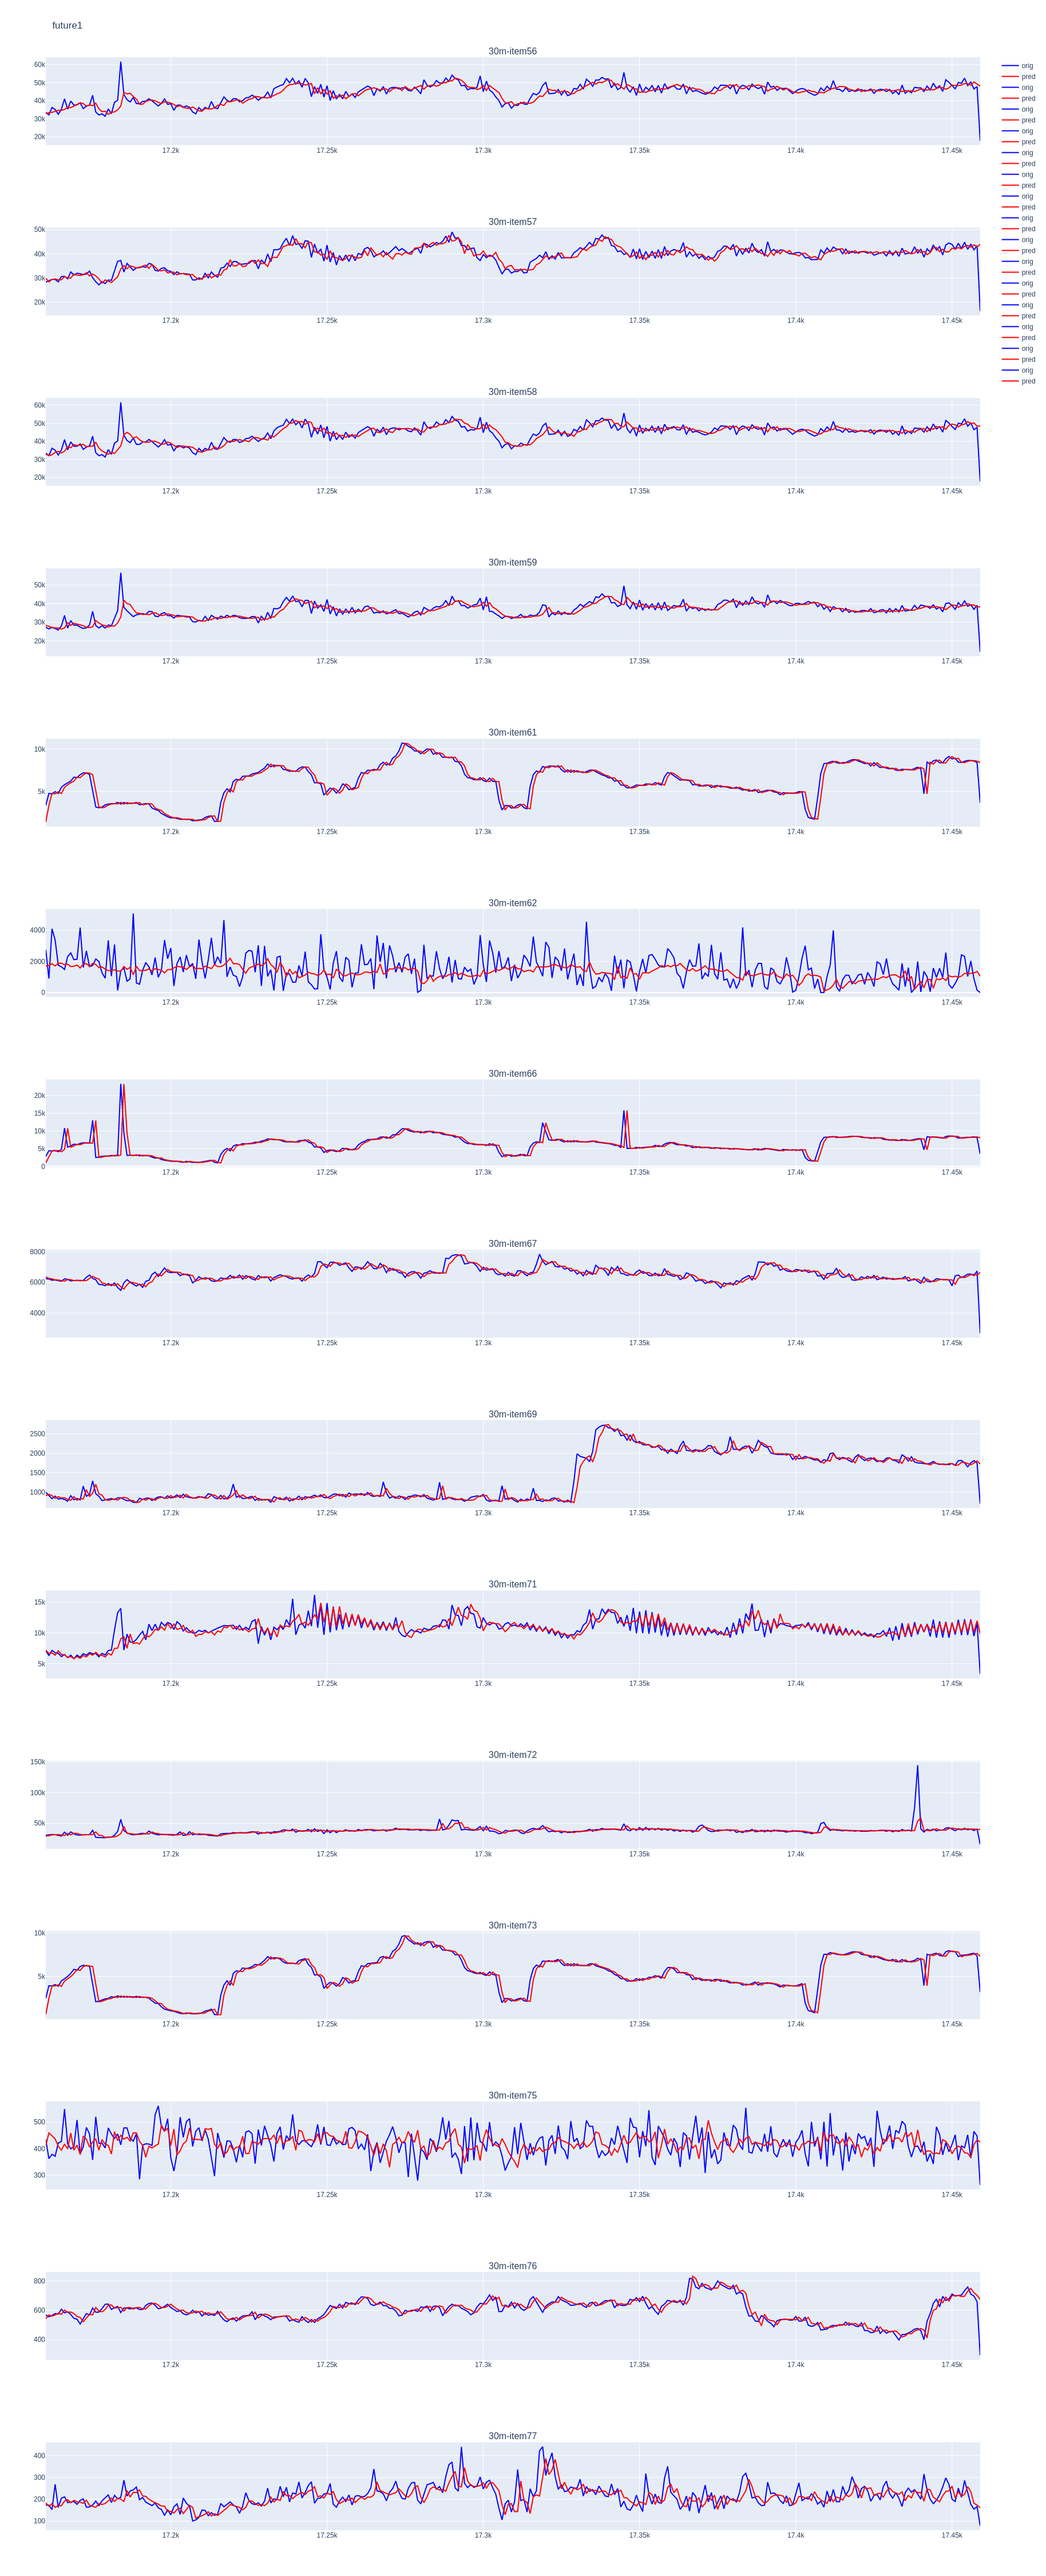

In [13]:
predspracovanie.draw_more("future1", list(models.keys()), orig, y_pred=pred)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
x1 = df['30m-item71'][-320:].index
fig.add_trace(go.Scatter(x=x1, y=df['30m-item71'][-320:],
                    mode='lines',
                    name='orig'))

In [ ]:
orig_from_percentage_change

In [ ]:
a = [1,2,3,4,5,6,7,8,9,10]
a = pd.DataFrame(a)
a

In [ ]:
a1 = predspracovanie.create_log_difference(a)
a1

In [ ]:
a2 = predspracovanie.back_from_log_difference(a[:-1].values, a1.values)

pd.DataFrame(a2).set_index(pd.concat(val_y).index[-9:])

In [ ]:
pd.concat(val_y).index[-9:]